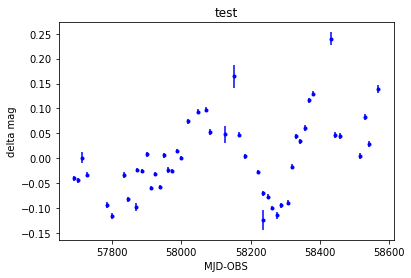

In [2]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [3]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.array(magerr_ref1[mask], dtype=float)
n=len(x)
X = np.reshape(x,(n,1))

In [44]:
muJ=np.asarray([-0.03425363, -0.03351397, -0.02664699, -0.02273714, -0.03174768,
       -0.03957353, -0.04738784, -0.05586893, -0.06363427, -0.07391645,
       -0.08178534, -0.08926872, -0.09593623, -0.09036217, -0.07807825,
       -0.06753805, -0.05767188, -0.06243789, -0.06809364, -0.06405182,
       -0.06114183, -0.04508844, -0.03290343, -0.02404407, -0.02079736,
       -0.03644591, -0.03598996, -0.03445805, -0.03331908, -0.01566788,
       -0.01656279, -0.01754197, -0.0130746 ,  0.00193958,  0.01056539,
        0.01698442,  0.0382919 ,  0.05958532,  0.06605687,  0.07316159,
        0.07929714,  0.08111757,  0.08236758,  0.08409051,  0.07132862,
        0.06410184,  0.06383741,  0.0638774 ,  0.06268115,  0.0642296 ,
        0.07699274,  0.09465466,  0.10719381,  0.07496593,  0.04823132,
        0.02464346,  0.00900288, -0.00262479, -0.01581547, -0.02713472,
       -0.04211868, -0.06695968, -0.0843794 , -0.0838455 , -0.09070336,
       -0.09610623, -0.09881969, -0.09027169, -0.08033855, -0.06809048,
       -0.04661056, -0.01563495,  0.0156263 ,  0.03325961,  0.04721029,
        0.0665903 ,  0.09242785,  0.10892494,  0.12218285,  0.1282392 ,
        0.13511139,  0.14373963,  0.15130526,  0.15932193,  0.1431794 ,
        0.08651746,  0.06932233,  0.05781805,  0.05321184,  0.04833902,
        0.04359331,  0.03972242,  0.03617235,  0.0324834 ,  0.04958008,
        0.05654622,  0.05459009,  0.07174552,  0.09021518,  0.10966458])
XK_new=np.linspace(57690.160596,58541.349392,100,dtype=np.float64)

muK = np.asarray([-0.0188423 , -0.01101513, -0.02182555, -0.04066994, -0.0372273 ,
       -0.04142979, -0.04643643, -0.05618733, -0.06305947, -0.07055236,
       -0.07793845, -0.08585502, -0.06063842, -0.04144011, -0.04482767,
       -0.05074738, -0.05828078, -0.06202257, -0.0469031 , -0.03229114,
       -0.01682147, -0.00109132,  0.01100408,  0.02217135,  0.00313528,
       -0.01391616, -0.02103778, -0.00784842, -0.00958049, -0.00958786,
        0.01109297, -0.00763489, -0.02091672, -0.01876265,  0.00469278,
        0.0188317 ,  0.03078942,  0.04751188,  0.06810743,  0.07498746,
        0.08292102,  0.08732753,  0.10046523,  0.11947633,  0.13786948,
        0.14400703,  0.13987333,  0.13111406,  0.12287179,  0.11626273,
        0.11051379,  0.09606653,  0.03146849, -0.03145527, -0.03731231,
        0.05864158,  0.10667121,  0.12383762,  0.11461967,  0.08906796,
        0.06559065,  0.04109558,  0.02030753, -0.00256419, -0.02360279,
       -0.04425853, -0.07565115, -0.11281323, -0.158842  , -0.15194773,
       -0.13758974, -0.12698046, -0.11453399, -0.09043922, -0.06368814,
       -0.03801246, -0.01361853,  0.01826796,  0.04772783,  0.0783482 ,
        0.10210635,  0.11343715,  0.11997221,  0.12888862,  0.14047052,
        0.1510065 ,  0.16296829,  0.15034888,  0.12048199,  0.10888384,
        0.10030352,  0.09039116,  0.08457157,  0.07565612,  0.06965578,
        0.06232899,  0.05684617,  0.07264807,  0.09185271,  0.10704618])

sdK= np.asarray([0.01988143, 0.02823802, 0.02842399, 0.02519744, 0.02685983,
       0.03892542, 0.05028333, 0.05689614, 0.05813455, 0.05403651,
       0.04471803, 0.02418143, 0.03161986, 0.02934869, 0.04177712,
       0.04655686, 0.03921996, 0.02387052, 0.02670243, 0.0358775 ,
       0.0404354 , 0.02561409, 0.03271019, 0.02208746, 0.03147129,
       0.02778667, 0.01997748, 0.02645743, 0.02909296, 0.02507729,
       0.02358237, 0.03032299, 0.02790866, 0.01985626, 0.02860159,
       0.02765181, 0.02107263, 0.03497932, 0.0255268 , 0.03756821,
       0.04205965, 0.03471579, 0.03107883, 0.03834469, 0.03036075,
       0.02955552, 0.0268117 , 0.04630602, 0.05364562, 0.0514371 ,
       0.04249924, 0.0266177 , 0.03959254, 0.04223779, 0.03861979,
       0.02962969, 0.03502534, 0.03253784, 0.03910857, 0.04728147,
       0.0472931 , 0.03952985, 0.0238944 , 0.03969748, 0.04179032,
       0.02498722, 0.03114984, 0.02718431, 0.02714058, 0.03081888,
       0.02916275, 0.0340881 , 0.02559767, 0.02691825, 0.03102352,
       0.02701771, 0.01996262, 0.02890135, 0.02935551, 0.02249271,
       0.02631584, 0.03960783, 0.05016029, 0.05681583, 0.05473107,
       0.04716982, 0.03231861, 0.02949984, 0.02315253, 0.0270892 ,
       0.03911139, 0.05046017, 0.05845151, 0.05975193, 0.05511116,
       0.04632993, 0.02836088, 0.02897927, 0.02732322, 0.02084374])

In [25]:
#Define simple planck function
h = 1#6.626e-34
c = 1#3.0e+8
k = 1#1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity
def transferDT(x,mu,sigma,A_T,wav,T):
    '''Defines the transfer function for the DT'''
    BB = planck(wav, T)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = A_T/(x*sigma*np.sqrt(2*np.pi))
    return BB*front*np.exp(exp)
#might need to include a normalization here
#can you determine the index of the power law? Maybe by a fit in a filter?
def power(wav,wav_0,K_0,index):
    powr=K_0*(wav/wav_0)**(index)
    return powr
def transferAD(x,mu,sigma,A_T,wav,wav_0,K_0,index):
    '''Defines the transfer function for the AD'''
    powr = power(wav, wav_0, K_0, index)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = (1.0-A_T)/(x*sigma*np.sqrt(2*np.pi))
    return powr*front*np.exp(exp)
def transfertot(x,mu_DT,mu_AD,sigma_DT,sigma_AD,A_T,T,wav,wav_0, K_0,index):
    transfer_DT = transferDT(x,mu_DT,sigma_DT,A_T,wav,T)
    transfer_AD = transferAD(x,mu_AD,sigma_AD,A_T,wav,wav_0,K_0,index)
    return transfer_DT + transfer_AD

In [244]:
sigma_DT_val=0.04
sigma_AD_val=0.04
mu_DT_val=11.0
mu_AD_val=11.0
A_T_val=0.5
T_val=1700.0
wav_val=10.0
wav_0_val=100.0
K_0_val=1.0
index_val=2.0

In [245]:
a=[0.08,0.08,0.08]
b=[0.1,0.1,0.1]
np.convolve(a,b,'same')

array([0.016, 0.024, 0.016])

In [246]:
planck(wav_val, T_val)

0.33999000009814

In [247]:
transferDT(X,mu_DT_val,sigma_DT_val,A_T_val,wav_val,T_val)

array([[1.90895672e-05],
       [1.91769098e-05],
       [1.92653329e-05],
       [1.93603140e-05],
       [1.97850943e-05],
       [1.98865677e-05],
       [2.01464507e-05],
       [2.02317768e-05],
       [2.03976752e-05],
       [2.04117243e-05],
       [2.05186215e-05],
       [2.06178930e-05],
       [2.07027568e-05],
       [2.07866534e-05],
       [2.08717487e-05],
       [2.09559877e-05],
       [2.10469109e-05],
       [2.11305867e-05],
       [2.12208812e-05],
       [2.13129683e-05],
       [2.14370123e-05],
       [2.16361970e-05],
       [2.18056555e-05],
       [2.18871017e-05],
       [2.21783192e-05],
       [2.23375382e-05],
       [2.24369161e-05],
       [2.25486015e-05],
       [2.28022025e-05],
       [2.28927471e-05],
       [2.28991475e-05],
       [2.29821544e-05],
       [2.30647188e-05],
       [2.31474521e-05],
       [2.32285766e-05],
       [2.33408718e-05],
       [2.34213152e-05],
       [2.34954626e-05],
       [2.35690379e-05],
       [2.36422140e-05],


In [248]:
power(wav_val,wav_0_val,K_0_val,index_val)

0.010000000000000002

In [249]:
transferAD(X,mu_AD_val,sigma_AD_val,A_T_val,wav_val,wav_0_val,K_0_val,index_val)

array([[5.61474374e-07],
       [5.64043347e-07],
       [5.66644105e-07],
       [5.69437749e-07],
       [5.81931655e-07],
       [5.84916253e-07],
       [5.92560096e-07],
       [5.95069760e-07],
       [5.99949269e-07],
       [6.00362489e-07],
       [6.03506617e-07],
       [6.06426455e-07],
       [6.08922521e-07],
       [6.11390142e-07],
       [6.13893017e-07],
       [6.16370708e-07],
       [6.19044998e-07],
       [6.21506123e-07],
       [6.24161921e-07],
       [6.26870445e-07],
       [6.30518907e-07],
       [6.36377453e-07],
       [6.41361673e-07],
       [6.43757219e-07],
       [6.52322692e-07],
       [6.57005740e-07],
       [6.59928705e-07],
       [6.63213667e-07],
       [6.70672740e-07],
       [6.73335896e-07],
       [6.73524149e-07],
       [6.75965598e-07],
       [6.78394035e-07],
       [6.80827437e-07],
       [6.83213523e-07],
       [6.86516421e-07],
       [6.88882474e-07],
       [6.91063344e-07],
       [6.93227385e-07],
       [6.95379688e-07],
